In [2]:
#Kiểm tra GPU được cấp phát
!nvidia-smi

Fri Nov 17 12:07:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Cài đặt bổ sung một số thư viện
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8a7e14cf44303871f03b20bf95ac2f5aff05c0ea7fafea543a8fe456468747f2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=41dde25e4bc8798bd294c0cd7686311ae008ff0d070

In [4]:
#Download dữ liệu
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-11-17 12:07:46--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-11-17 12:07:47--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  25.0MB/s    in 31s     

2023-11-17 12:08:18 (24.5 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-11-17 12:08:18--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [5]:
#Giải nén dữ liệu
!tar -xf annotations.tar.gz
!tar -xf images.tar.gz

In [6]:
#Import thư viện
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

[1 2 3]


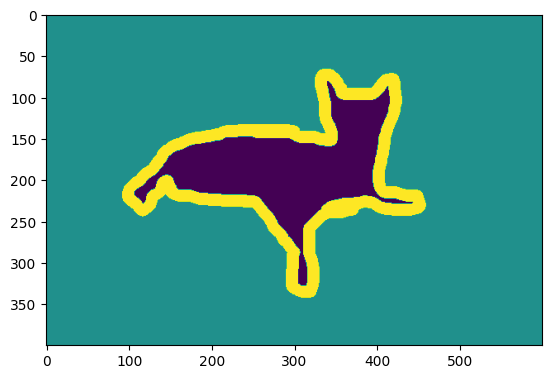

In [7]:
mask_path = "/content/annotations/trimaps/Abyssinian_1.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
print(np.unique(mask))

In [ ]:
image_path = "/content/images/Abyssinian_10.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

In [9]:
#Định nghĩa Dataset
class DogCatDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None): #transform: augmentation + norm + np.array -> torch.tensor
        super().__init__()
        self.root_dir = root_dir
        self.txt_file = txt_file
        self.transform = transform
        self.img_path_lst = []
        with open(self.txt_file) as file_in:
            for line in file_in:
                self.img_path_lst.append(line.split(" ")[0])

    def __len__(self):
        return len(self.img_path_lst)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, "images", "{}.jpg".format(self.img_path_lst[idx]))
        mask_path = os.path.join(self.root_dir, "annotations", "trimaps", "{}.png".format(self.img_path_lst[idx]))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # foreground -> 1
        # background 2 -> 0
        # 3 -> 1
        mask[mask == 2] = 0
        mask[mask == 3] = 1
        # image (RGB), mask (2D matrix)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
        return transformed_image, transformed_mask

In [10]:
#Định nghĩa các phép augmentation trên ảnh
#Sử dụng thư viện Albumentations

trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [11]:
#Đoạn code dùng để convert ảnh sau khi đã chuẩn hoá thành ảnh ban đầu

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

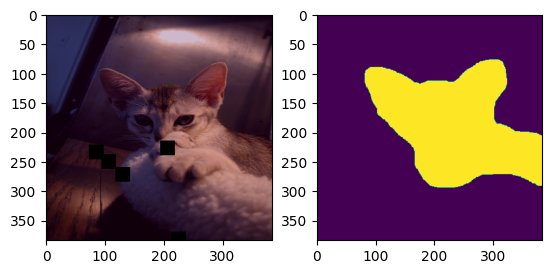

In [12]:
#kiểm tra 1 cặp ảnh đầu vào và ảnh kết quả phân vùng trước khi đưa vào mô hình training

train_dataset = DogCatDataset("/content", "/content/annotations/trainval.txt", train_transform)
test_dataset = DogCatDataset("/content", "/content/annotations/test.txt", test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [13]:
#Lập trình mô hình UNet cơ bản
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

model = UNet(1)
x = torch.rand(4, 3, trainsize, trainsize)
print("Input shape =", x.shape)
y = model(x).squeeze()
print("Output shape = ", y.shape)
#y true (4, 384, 384)
#y hat.squeeze() (4, 1, 384, 384) -> (4, 384, 384)

Input shape = torch.Size([4, 3, 384, 384])
Output shape =  torch.Size([4, 384, 384])


In [14]:
#Tạo AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
#Lập trình hàm tính toán độ chính xác

#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]


In [16]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = UNet(1).to(device)

#loss
criterion = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


In [ ]:
for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze() # -> logit (-vc, +vc)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long() # -> mask (0, 1)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "/content/model_ep_{}.pth".format(ep))

100%|██████████| 460/460 [08:02<00:00,  1.05s/it]


EP 1, train loss = 0.5621276836032453, accuracy = 0.7132121075106703, IoU = 0.4372527405232209, dice = 0.6704079052676325


100%|██████████| 460/460 [07:55<00:00,  1.03s/it]


EP 2, train loss = 0.5149655971838081, accuracy = 0.7571158572383548, IoU = 0.5239163801721904, dice = 0.7433025961336882


100%|██████████| 460/460 [07:56<00:00,  1.04s/it]


EP 3, train loss = 0.48840970882902973, accuracy = 0.7752224139545275, IoU = 0.5623258194197779, dice = 0.7643990633280381


100%|██████████| 460/460 [07:57<00:00,  1.04s/it]


EP 4, train loss = 0.4400419229398603, accuracy = 0.8020441324814506, IoU = 0.6097530949374904, dice = 0.7933724627546642


100%|██████████| 460/460 [07:57<00:00,  1.04s/it]


EP 5, train loss = 0.40756090860004013, accuracy = 0.8191663056612015, IoU = 0.6372836649417877, dice = 0.8108805362297141


100%|██████████| 460/460 [07:57<00:00,  1.04s/it]


EP 6, train loss = 0.37672558345872426, accuracy = 0.8351164543110391, IoU = 0.6655626392882803, dice = 0.8278115930764571


100%|██████████| 460/460 [07:57<00:00,  1.04s/it]


EP 7, train loss = 0.3461479116069234, accuracy = 0.8502328796231229, IoU = 0.6908375199722208, dice = 0.8434142132168231


 86%|████████▌ | 395/460 [06:50<01:07,  1.03s/it]

In [ ]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

In [ ]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())